# Homework 09 — IANNwTF
## Group 27
Deadline: Jan 16, 2021 23:59

<https://forms.gle/n6ERdhYx3uBPzuGn9>


In [25]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# The Quick, Draw! Dataset

In [26]:
import os
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [27]:
import urllib
categories = [line.rstrip(b'\n') for line in urllib.request.urlopen('https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt')]
print(categories[:10])
category = 'candle'

[b'aircraft carrier', b'airplane', b'alarm clock', b'ambulance', b'angel', b'animal migration', b'ant', b'anvil', b'apple', b'arm']


In [28]:
# Creates a folder to download the original drawings into.
# We chose to use the numpy format : 1x784 pixel vectors, with values going from 0 (white) to 255 (black). We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]

if not os.path.isdir('npy_files'):
    os.mkdir('npy_files')
    
url = f'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{category}.npy'  
urllib.request.urlretrieve(url, f'npy_files/{category}.npy')

images = np.load(f'npy_files/{category}.npy')
print(f'{len(images)} images available')

# You can limit the amount of images you use for training by setting :
train_images = images[:10000]
# You should also define a samller subset of the images for testing..
test_images = images[100000:]

print()
print(f'{len(train_images)} images used for training')
print(f'{len(test_images)} images used for testing')


# Notice that this to numpy format contains 1x784 pixel vectors, with values going from 0 (white) to 255 (black). We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]

141545 images available

10000 images used for training
41545 images used for testing


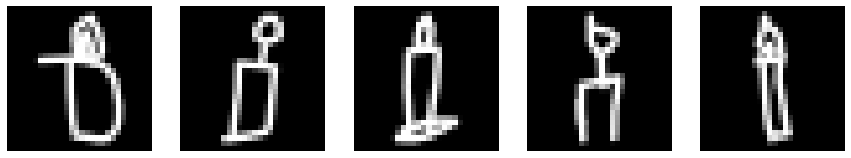

In [29]:
# show example images
npics = 5
fig, ax = plt.subplots(nrows=1, ncols=npics, figsize=(15,3))
ax = ax.flatten()
for i in range(5):
    ax[i].imshow(np.reshape(train_images[i], (28, 28)), cmap='gray', vmin=0, vmax=255)
    ax[i].axis("off")

# Preprocessing

In [30]:
def prepare_data(image_array):

  # create dataset from array
  ds = tf.data.Dataset.from_tensor_slices(image_array)
  # cast tensors to float32
  ds = ds.map(lambda img: tf.cast(img, tf.float32))
  # reshape the pixel arrays to images
  ds = ds.map(lambda img: tf.reshape(img, (28,28,1)))
  # normalize (bring values to a range from -1 to 1)
  ds = ds.map(lambda img: ((img/128.)-1.))
  # shuffle, batch, prefetch
  ds = ds.shuffle(1000).batch(32).prefetch(20)

  return ds


In [31]:
train_ds = prepare_data(train_images)
test_ds = prepare_data(test_images)

# Model: GAN

In [32]:
class Discriminator(tf.keras.Model):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.layers_1 = [# first convolution
                     tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(28, 28, 1)),
                     tf.keras.layers.Dropout(0.3)]
    self.bn_1 = tf.keras.layers.BatchNormalization()
    self.layers_2 = [tf.keras.layers.MaxPooling2D(2, 2),
                     # second convolution
                      tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
                      tf.keras.layers.Dropout(0.3)]
    self.bn_2 = tf.keras.layers.BatchNormalization()
    self.layers_3 = [tf.keras.layers.MaxPooling2D(2, 2),
                     # third convolution
                      tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
                      tf.keras.layers.Dropout(0.3)]
    self.bn_3 = tf.keras.layers.BatchNormalization()
    self.layers_4 = [tf.keras.layers.MaxPooling2D(2,2),
                     # flatten, dense, output
                    tf.keras.layers.Flatten(),
                    tf.keras.layers.Dense(512, activation='relu'),
                    tf.keras.layers.Dense(1, activation='sigmoid')]
  
  def call(self, x, training=True):
    for layer in self.layers_1:
      x = layer(x)
    x = self.bn_1(x, training = training)
    for layer in self.layers_2:
      x = layer(x)
    x = self.bn_2(x, training = training)
    for layer in self.layers_3:
      x = layer(x)
    x = self.bn_3(x, training = training)
    for layer in self.layers_4:
      x = layer(x)

    return x


In [33]:
class Generator(tf.keras.Model):
  def __init__(self):
    super(Generator, self).__init__()
    self.layers_list = []

  
  def call(self, x):
    for layer in self.layers_list:
      x = layer(x)
    return x




# Training